### Catboost model - with feature engineering

#### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics, preprocessing, model_selection
#from sklearn.ensemble import RandomForestClassifier
#import lightgbm as lgb
from catboost import CatBoostClassifier
import os
%matplotlib inline
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

In [2]:
import catboost as cb

In [4]:
import sklearn as sk

#### show versions

In [5]:
print(pd.__version__)
print(np.__version__)
print(cb.__version__)
print(sk.__version__)

1.1.3
1.19.2
0.24.4
0.23.2


### Define functions

In [3]:
### Function perform label encoding
def do_labelenc(train=None,test=None,cat_cols=None):
    enc_dict = {}
    
    if test is None:
        for col in cat_cols:
            print(col)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[col].values.astype('str')))
            train[col+'lab_enc'] = lbl.transform(list(train[col].values.astype('str')))
            enc_dict[col] = lbl
    else:
        for col in cat_cols:
            print(col)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(train[col].values.astype('str'))+list(test[col].values.astype('str')))
            train[col+'_lab_enc'] = lbl.transform(list(train[col].values.astype('str')))
            test[col+'_lab_enc'] = lbl.transform(list(test[col].values.astype('str')))
            enc_dict[col] = lbl
            
    return enc_dict

#function for null imputation
def null_impute(df, impute_dict):
    for col, val in impute_dict.items():
        if col not in df.columns:
            print(f"column: {col} not in dataframe")
            continue
        if df[col].isnull().any():
            dtype_ = df[col].dtype
            df[col] = df[col].fillna(val).astype(dtype_)
    return df

#function to check profile of a dataframe
def df_profile(data_frame = None):
    #import pandas as pd, numpy as np
    #read the csv file
    d = []
    for column in data_frame.columns:
        d.append({'column_name': column,
                  'data_type': data_frame[column].dtype,
                  'total_cnt': data_frame[column].size,
                  'not_null_col_cnt': data_frame[column].count(),
                  'null_count': sum(pd.isnull(data_frame[column])),
                  #'inf_count': sum(np.isinf(data_frame[column])),
                  #'nan_count': sum(np.isnan(data_frame[column])),
                  'unique_count': data_frame[column].nunique(),
                  'null_by_total_cnt': sum(pd.isnull(data_frame[column]))/data_frame[column].size,
                  'unique_by_not_null_cnt': data_frame[column].nunique()/data_frame[column].count(),
                  'unique_by_total_cnt': data_frame[column].nunique()/data_frame[column].size
                 })
        
    #d 
    
    df = pd.DataFrame(d,columns=d[0].keys())
    
    return df


#function run a catboost model
def runCB(dev_X, dev_y, val_X, val_y=None,categorical_feature_indices=None): 
    params = {  
        'iterations': 1000,
        'learning_rate': 0.1,
        'eval_metric': 'AUC',
        'random_seed': SEED,
        'logging_level': 'Silent',
        'use_best_model': True,
        #'max_leaves': 256,
        'min_data_in_leaf': 30,
        'sampling_frequency': 'PerTree',
        'subsample': 0.7,
        'one_hot_max_size': 6,
        'l2_leaf_reg': 2,
        'model_size_reg': 1,
        'grow_policy': 'SymmetricTree',
        'bootstrap_type': 'MVS',
        'boosting_type': 'Plain',
        'boost_from_average': False,
        'class_weights': [1,1],
        'custom_metric': ['F1']
    }
    
    model = CatBoostClassifier(**params)

    if val_y is not None:
        model.fit(
                  dev_X, dev_y,
                  eval_set=(val_X,val_y),
                  cat_features=categorical_feature_indices,
                  logging_level='Verbose',
                  plot=True,
                  early_stopping_rounds=50
                 )
    else:
        model.fit(
                  dev_X, dev_y,
                  cat_features=categorical_features_indices,
                  logging_level='Verbose',
                  plot=True
                 )

    return model

#function to plot feature importance
def plot_cb_imp(trainX=None, model=None, n=10, fs=(10,8)):
    sns.set(style="whitegrid")
    feats={}
    for feature, importance in zip(trainX.columns, model.feature_importances_):
        feats[feature] = importance
        
    importances = pd.DataFrame.from_dict(feats,orient='index')
    importances.columns = ["imp"]
    importances = importances.sort_values(by="imp").tail(n)
    
    fig, ax = plt.subplots(figsize=fs)
    y_pos = np.arange(len(importances))
    ax.barh(y_pos, importances["imp"],color="blue",ecolor="black")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importances.index)
    plt.show()
    
    return importances

#### Some constants

In [4]:
TARGET_VAR = 'Response'
SEED=2021
data_path = r'C:\Users\91810\Data_2\analytics_vidhya\Job a-thon 2021\data\\'
train = pd.read_csv(os.path.join(data_path,"train_Df64byy.csv"))
test = pd.read_csv(os.path.join(data_path,"test_YCcRUnU.csv"))

In [5]:
print(train.shape)
train.head()

(50882, 14)


ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   
3   4       C24         4378             Owned               Joint         52   
4   5        C8         2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   
3         48        No               X1                     14+   
4         44        No               X2                     3.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  
0                  3.0               22              11628.0         0  
1                  NaN               22              30510.0         0  
2                  1.0               19               7450.0         1  
3                  3.0               19              17780.0         0  
4                  1.0               16              10404.0         0

In [6]:
train.Holding_Policy_Duration.unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

In [7]:
print(test.shape)
test.head()

(21805, 13)


ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  \
0  50883        C1          156             Owned          Individual   
1  50884        C4            7             Owned               Joint   
2  50885        C1          564            Rented          Individual   
3  50886        C3         1177            Rented          Individual   
4  50887        C1          951             Owned          Individual   

   Upper_Age  Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         30         30        No              NaN                     6.0   
1         69         68       Yes               X1                     3.0   
2         28         28        No               X3                     2.0   
3         23         23        No               X3                     3.0   
4         75         75        No               X3                     NaN   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  
0                  3.0                5              11934.0  
1                  3.0               18              32204.8  
2                  4.0               17               9240.0  
3                  3.0               18               9086.0  
4                  NaN                5              22534.0

In [8]:
train.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [9]:
df_profile(train)

column_name data_type  total_cnt  not_null_col_cnt  \
0                        ID     int64      50882             50882   
1                 City_Code    object      50882             50882   
2               Region_Code     int64      50882             50882   
3         Accomodation_Type    object      50882             50882   
4       Reco_Insurance_Type    object      50882             50882   
5                 Upper_Age     int64      50882             50882   
6                 Lower_Age     int64      50882             50882   
7                 Is_Spouse    object      50882             50882   
8          Health Indicator    object      50882             39191   
9   Holding_Policy_Duration    object      50882             30631   
10      Holding_Policy_Type   float64      50882             30631   
11          Reco_Policy_Cat     int64      50882             50882   
12      Reco_Policy_Premium   float64      50882             50882   
13                 Response     int64      50882             50882   

    null_count  unique_count  null_by_total_cnt  unique_by_not_null_cnt  \
0            0         50882           0.000000                1.000000   
1            0            36           0.000000                0.000708   
2            0          5316           0.000000                0.104477   
3            0             2           0.000000                0.000039   
4            0             2           0.000000                0.000039   
5            0            58           0.000000                0.001140   
6            0            60           0.000000                0.001179   
7            0             2           0.000000                0.000039   
8        11691             9           0.229767                0.000230   
9        20251            15           0.397999                0.000490   
10       20251             4           0.397999                0.000131   
11           0            22           0.000000                0.000432   
12           0          6977           0.000000                0.137121   
13           0             2           0.000000                0.000039   

    unique_by_total_cnt  
0              1.000000  
1              0.000708  
2              0.104477  
3              0.000039  
4              0.000039  
5              0.001140  
6              0.001179  
7              0.000039  
8              0.000177  
9              0.000295  
10             0.000079  
11             0.000432  
12             0.137121  
13             0.000039

In [10]:
df_profile(test)

column_name data_type  total_cnt  not_null_col_cnt  \
0                        ID     int64      21805             21805   
1                 City_Code    object      21805             21805   
2               Region_Code     int64      21805             21805   
3         Accomodation_Type    object      21805             21805   
4       Reco_Insurance_Type    object      21805             21805   
5                 Upper_Age     int64      21805             21805   
6                 Lower_Age     int64      21805             21805   
7                 Is_Spouse    object      21805             21805   
8          Health Indicator    object      21805             16778   
9   Holding_Policy_Duration    object      21805             13202   
10      Holding_Policy_Type   float64      21805             13202   
11          Reco_Policy_Cat     int64      21805             21805   
12      Reco_Policy_Premium   float64      21805             21805   

    null_count  unique_count  null_by_total_cnt  unique_by_not_null_cnt  \
0            0         21805           0.000000                1.000000   
1            0            36           0.000000                0.001651   
2            0          4694           0.000000                0.215272   
3            0             2           0.000000                0.000092   
4            0             2           0.000000                0.000092   
5            0            58           0.000000                0.002660   
6            0            60           0.000000                0.002752   
7            0             2           0.000000                0.000092   
8         5027             9           0.230543                0.000536   
9         8603            15           0.394543                0.001136   
10        8603             4           0.394543                0.000303   
11           0            22           0.000000                0.001009   
12           0          5226           0.000000                0.239670   

    unique_by_total_cnt  
0              1.000000  
1              0.001651  
2              0.215272  
3              0.000092  
4              0.000092  
5              0.002660  
6              0.002752  
7              0.000092  
8              0.000413  
9              0.000688  
10             0.000183  
11             0.001009  
12             0.239670

#### Perform label encoding

In [11]:
cat_cols = ['City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type','Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration','Holding_Policy_Type',
       'Reco_Policy_Cat']
lab_enc_objs = do_labelenc(train=train,test=test,cat_cols=cat_cols)

City_Code
Region_Code
Accomodation_Type
Reco_Insurance_Type
Is_Spouse
Health Indicator
Holding_Policy_Duration
Holding_Policy_Type
Reco_Policy_Cat


In [12]:
train.head()

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   
3   4       C24         4378             Owned               Joint         52   
4   5        C8         2190            Rented          Individual         44   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   
3         48        No               X1                     14+   
4         44        No               X2                     3.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  \
0                  3.0               22              11628.0         0   
1                  NaN               22              30510.0         0   
2                  1.0               19               7450.0         1   
3                  3.0               19              17780.0         0   
4                  1.0               16              10404.0         0   

   City_Code_lab_enc  Region_Code_lab_enc  Accomodation_Type_lab_enc  \
0                 22                 2137                          1   
1                 31                  117                          0   
2                 31                 2664                          0   
3                 16                 3322                          0   
4                 34                 1151                          1   

   Reco_Insurance_Type_lab_enc  Is_Spouse_lab_enc  Health Indicator_lab_enc  \
0                            0                  0                         0   
1                            1                  0                         1   
2                            0                  0                         9   
3                            1                  0                         0   
4                            0                  0                         1   

   Holding_Policy_Duration_lab_enc  Holding_Policy_Type_lab_enc  \
0                                5                            2   
1                               15                            4   
2                                0                            0   
3                                5                            2   
4                                8                            0   

   Reco_Policy_Cat_lab_enc  
0                       14  
1                       14  
2                       10  
3                       10  
4                        7

In [13]:
train_df = train.copy()
test_df = test.copy()

### Create some features

In [14]:
train_df["is_train"] = 1
test_df["is_train"] = 0
all_df = pd.concat([train_df,test_df],axis=0).reset_index(drop=True)
all_df["age_ratio"] = all_df["Upper_Age"]/all_df["Lower_Age"]
all_df["age_diff"] = all_df["Upper_Age"]-all_df["Lower_Age"]
all_df["age_sum"] = all_df["Upper_Age"]+all_df["Lower_Age"]

In [15]:

gdf = all_df.groupby("Reco_Policy_Cat_lab_enc")["Upper_Age"].agg(['mean','median','std']).reset_index()

In [16]:
gdf = all_df.groupby(["Reco_Policy_Cat_lab_enc","Region_Code_lab_enc"])["Upper_Age"].agg(['mean','median','std']).reset_index()

In [17]:
col = ["Reco_Policy_Cat_lab_enc","Region_Code_lab_enc"]
if isinstance(col, list):
    col = "_".join(col)
col

'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc'

In [18]:
#function to create statistical features of columns
def create_stat_features(df,grp_col,stat_col):
    gdf = df.groupby(grp_col)[stat_col].agg(['mean','median','std']).reset_index()
    col = ["Reco_Policy_Cat_lab_enc","Region_Code_lab_enc"]
    col = "_".join(grp_col)
    col = col+'_'+stat_col
    gdf.columns = grp_col + [col+'_mean',col+'_median',col+'_std']
    gdf = gdf.fillna(0.)
    df = pd.merge(df,gdf,how="left",on=grp_col)
    
    return df

#### Create statistical features

In [19]:
#stats features for Reco_Policy_Cat
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc'],stat_col='Upper_Age')
print(all_df.shape)

(72687, 27)
(72687, 30)


In [20]:
#stats features for Reco_Policy_Cat
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc'],stat_col='Lower_Age')
print(all_df.shape)

(72687, 30)
(72687, 33)


In [21]:
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc'],stat_col='Reco_Policy_Premium')
print(all_df.shape)

(72687, 33)
(72687, 36)


In [22]:
#stats features for Region_Code_lab_enc
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Region_Code_lab_enc'],stat_col='Upper_Age')
print(all_df.shape)

(72687, 36)
(72687, 39)


In [23]:
#stats features for Region_Code_lab_enc
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Region_Code_lab_enc'],stat_col='Lower_Age')
print(all_df.shape)

(72687, 39)
(72687, 42)


In [24]:
#stats features for Region_Code_lab_enc
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Region_Code_lab_enc'],stat_col='Reco_Policy_Premium')
print(all_df.shape)

(72687, 42)
(72687, 45)


In [25]:
#stats features for Reco_Policy_Cat_lab_enc and Region_Code_lab_enc combination
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc','Region_Code_lab_enc'],stat_col='Upper_Age')
print(all_df.shape)

(72687, 45)
(72687, 48)


In [26]:
#stats features for Reco_Policy_Cat_lab_enc and Region_Code_lab_enc combination
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc','Region_Code_lab_enc'],stat_col='Lower_Age')
print(all_df.shape)

(72687, 48)
(72687, 51)


In [27]:
#stats features for Reco_Policy_Cat_lab_enc and Region_Code_lab_enc combination
print(all_df.shape)
all_df = create_stat_features(df=all_df,grp_col=['Reco_Policy_Cat_lab_enc','Region_Code_lab_enc'],stat_col='Reco_Policy_Premium')
print(all_df.shape)

(72687, 51)
(72687, 54)


#### Create mean and median difference features

In [28]:
all_df["Reco_Policy_Cat_lab_enc_Upper_Age_mean_diff"] = all_df["Upper_Age"] - all_df["Reco_Policy_Cat_lab_enc_Upper_Age_mean"]
all_df["Reco_Policy_Cat_lab_enc_Upper_Age_median_diff"] = all_df["Upper_Age"] - all_df["Reco_Policy_Cat_lab_enc_Upper_Age_median"]
all_df["Reco_Policy_Cat_lab_enc_Lower_Age_mean_diff"] = all_df["Lower_Age"] - all_df["Reco_Policy_Cat_lab_enc_Lower_Age_mean"]
all_df["Reco_Policy_Cat_lab_enc_Lower_Age_median_diff"] = all_df["Lower_Age"] - all_df["Reco_Policy_Cat_lab_enc_Lower_Age_median"]
all_df["Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mean_diff"] = all_df["Reco_Policy_Premium"] - all_df["Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mean"]
all_df["Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_median_diff"] = all_df["Reco_Policy_Premium"] - all_df["Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_median"]

all_df["Region_Code_lab_enc_Upper_Age_mean_diff"] = all_df["Upper_Age"] - all_df["Region_Code_lab_enc_Upper_Age_mean"]
all_df["Region_Code_lab_enc_Upper_Age_median_diff"] = all_df["Upper_Age"] - all_df["Region_Code_lab_enc_Upper_Age_median"]
all_df["Region_Code_lab_enc_Lower_Age_mean_diff"] = all_df["Lower_Age"] - all_df["Region_Code_lab_enc_Lower_Age_mean"]
all_df["Region_Code_lab_enc_Lower_Age_median_diff"] = all_df["Lower_Age"] - all_df["Region_Code_lab_enc_Lower_Age_median"]
all_df["Region_Code_lab_enc_Reco_Policy_Premium_mean_diff"] = all_df["Reco_Policy_Premium"] - all_df["Region_Code_lab_enc_Reco_Policy_Premium_mean"]
all_df["Region_Code_lab_enc_Reco_Policy_Premium_median_diff"] = all_df["Reco_Policy_Premium"] - all_df["Region_Code_lab_enc_Reco_Policy_Premium_median"]

all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_mean_diff"] = all_df["Upper_Age"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_mean"]
all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_median_diff"] = all_df["Upper_Age"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_median"]
all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_mean_diff"] = all_df["Lower_Age"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_mean"]
all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_median_diff"] = all_df["Lower_Age"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_median"]
all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_mean_diff"] = all_df["Reco_Policy_Premium"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_mean"]
all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_median_diff"] = all_df["Reco_Policy_Premium"] - all_df["Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_median"]

In [29]:
all_df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response',
       'City_Code_lab_enc', 'Region_Code_lab_enc', 'Accomodation_Type_lab_enc',
       'Reco_Insurance_Type_lab_enc', 'Is_Spouse_lab_enc',
       'Health Indicator_lab_enc', 'Holding_Policy_Duration_lab_enc',
       'Holding_Policy_Type_lab_enc', 'Reco_Policy_Cat_lab_enc', 'is_train',
       'age_ratio', 'age_diff', 'age_sum',
       'Reco_Policy_Cat_lab_enc_Upper_Age_mean',
       'Reco_Policy_Cat_lab_enc_Upper_Age_median',
       'Reco_Policy_Cat_lab_enc_Upper_Age_std',
       'Reco_Policy_Cat_lab_enc_Lower_Age_mean',
       'Reco_Policy_Cat_lab_enc_Lower_Age_median',
       'Reco_Policy_Cat_lab_enc_Lower_Age_std',
       'Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mean',
       'Reco_Policy_Cat_lab_enc_Reco_Policy_Pre

In [30]:
all_df.head(3)

ID City_Code  Region_Code Accomodation_Type Reco_Insurance_Type  Upper_Age  \
0   1        C3         3213            Rented          Individual         36   
1   2        C5         1117             Owned               Joint         75   
2   3        C5         3732             Owned          Individual         32   

   Lower_Age Is_Spouse Health Indicator Holding_Policy_Duration  \
0         36        No               X1                     14+   
1         22        No               X2                     NaN   
2         32        No              NaN                     1.0   

   Holding_Policy_Type  Reco_Policy_Cat  Reco_Policy_Premium  Response  \
0                  3.0               22              11628.0       0.0   
1                  NaN               22              30510.0       0.0   
2                  1.0               19               7450.0       1.0   

   City_Code_lab_enc  Region_Code_lab_enc  Accomodation_Type_lab_enc  \
0                 22                 2137                          1   
1                 31                  117                          0   
2                 31                 2664                          0   

   Reco_Insurance_Type_lab_enc  Is_Spouse_lab_enc  Health Indicator_lab_enc  \
0                            0                  0                         0   
1                            1                  0                         1   
2                            0                  0                         9   

   Holding_Policy_Duration_lab_enc  Holding_Policy_Type_lab_enc  \
0                                5                            2   
1                               15                            4   
2                                0                            0   

   Reco_Policy_Cat_lab_enc  is_train  age_ratio  age_diff  age_sum  \
0                       14         1   1.000000         0       72   
1                       14         1   3.409091        53       97   
2                       10         1   1.000000         0       64   

   Reco_Policy_Cat_lab_enc_Upper_Age_mean  \
0                               44.595306   
1                               44.595306   
2                               45.305697   

   Reco_Policy_Cat_lab_enc_Upper_Age_median  \
0                                      43.0   
1                                      43.0   
2                                      44.0   

   Reco_Policy_Cat_lab_enc_Upper_Age_std  \
0                              17.319650   
1                              17.319650   
2                              16.943133   

   Reco_Policy_Cat_lab_enc_Lower_Age_mean  \
0                               42.263347   
1                               42.263347   
2                               43.082722   

   Reco_Policy_Cat_lab_enc_Lower_Age_median  \
0                                      40.0   
1                                      40.0   
2                                      41.0   

   Reco_Policy_Cat_lab_enc_Lower_Age_std  \
0                              17.318594   
1                              17.318594   
2                              16.952268   

   Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mean  \
0                                      14589.814674   
1                                      14589.814674   
2                                      14714.576838   

   Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_median  \
0                                            13504.4    
1                                            13504.4    
2                                            13840.0    

   Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_std  \
0                                      6868.779085   
1                                      6868.779085   
2                                      6554.578004   

   Region_Code_lab_enc_Upper_Age_mean  Region_Code_lab_enc_Upper_Age_median  \
0                           40.700000                                  37.0   
1                           41.333333

#### Get back train and test df from the combined df

In [31]:
train_df = all_df.loc[all_df["is_train"] == 1].reset_index(drop=True)
test_df = all_df.loc[all_df["is_train"] == 0].reset_index(drop=True)

In [32]:
###columns for training
x_col = [ 'Upper_Age', 'Lower_Age',
       'Reco_Policy_Premium',
       'City_Code_lab_enc', 'Region_Code_lab_enc', 'Accomodation_Type_lab_enc',
       'Reco_Insurance_Type_lab_enc', 'Is_Spouse_lab_enc',
       'Health Indicator_lab_enc', 'Holding_Policy_Duration_lab_enc',
       'Holding_Policy_Type_lab_enc', 'Reco_Policy_Cat_lab_enc',
       'age_ratio', 'age_diff', 'age_sum',
       'Reco_Policy_Cat_lab_enc_Upper_Age_std',
       'Reco_Policy_Cat_lab_enc_Lower_Age_std',
       'Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_std',
       'Region_Code_lab_enc_Upper_Age_std',
       'Region_Code_lab_enc_Lower_Age_std',
       'Region_Code_lab_enc_Reco_Policy_Premium_std',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_std',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_std',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_std',
       'Reco_Policy_Cat_lab_enc_Upper_Age_mean_diff',
       'Reco_Policy_Cat_lab_enc_Upper_Age_median_diff',
       'Reco_Policy_Cat_lab_enc_Lower_Age_mean_diff',
       'Reco_Policy_Cat_lab_enc_Lower_Age_median_diff',
       'Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mean_diff',
       'Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_median_diff',
       'Region_Code_lab_enc_Upper_Age_mean_diff',
       'Region_Code_lab_enc_Upper_Age_median_diff',
       'Region_Code_lab_enc_Lower_Age_mean_diff',
       'Region_Code_lab_enc_Lower_Age_median_diff',
       'Region_Code_lab_enc_Reco_Policy_Premium_mean_diff',
       'Region_Code_lab_enc_Reco_Policy_Premium_median_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_mean_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upper_Age_median_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_mean_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Lower_Age_median_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_mean_diff',
       'Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Reco_Policy_Premium_median_diff']

y_col = 'Response'
cat_ind = [3,4,5,6,7,8,9,10,11]

In [33]:
#train 5 different models using k-fold cross validation
#supplying categorical columns manually
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=SEED)
cv_scores_train = []
cv_scores_val = []
models = []
Response = 0
test_X = test_df[x_col]
for fold_idx, (dev_idx, val_idx) in enumerate(kf.split(train_df)):
    print(f"Fold: {fold_idx+1}")
    dev_X, dev_y = train_df.loc[dev_idx, x_col], train_df.loc[dev_idx, y_col].values
    val_X, val_y = train_df.loc[val_idx, x_col], train_df.loc[val_idx, y_col].values
    
    model = runCB(dev_X, dev_y, val_X, val_y=val_y,categorical_feature_indices=cat_ind)
    Response += model.predict_proba(test_X)[:,1]
    
    pred_dev = model.predict(dev_X)
    pred_probs_dev = model.predict_proba(dev_X)[:,1]
    pred_val = model.predict(val_X)
    pred_probs_val = model.predict_proba(val_X)[:,1]
    
    dev_auc = metrics.roc_auc_score(dev_y,pred_probs_dev)
    val_auc = metrics.roc_auc_score(val_y,pred_probs_val)
    
    print(f"\n Train AUC score: {dev_auc}")
    print(f"\n Train confusion matrix:\n {metrics.confusion_matrix(dev_y,pred_dev)}")
    print(f"\n Train classification report:\n {metrics.classification_report(dev_y,pred_dev)}")
    
    print(f"\n Val AUC score: {val_auc}")
    print(f"\n Val confusion matrix:\n {metrics.confusion_matrix(val_y,pred_val)}")
    print(f"\n Val classification report:\n {metrics.classification_report(val_y,pred_val)}")
    
    cv_scores_train.append(dev_auc)
    cv_scores_val.append(val_auc)
    
    models.append(model)

Fold: 1


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6881945	best: 0.6881945 (0)	total: 280ms	remaining: 4m 39s
1:	test: 0.7124144	best: 0.7124144 (1)	total: 392ms	remaining: 3m 15s
2:	test: 0.7170417	best: 0.7170417 (2)	total: 497ms	remaining: 2m 45s
3:	test: 0.7192395	best: 0.7192395 (3)	total: 618ms	remaining: 2m 33s
4:	test: 0.7267876	best: 0.7267876 (4)	total: 789ms	remaining: 2m 36s
5:	test: 0.7305960	best: 0.7305960 (5)	total: 935ms	remaining: 2m 34s
6:	test: 0.7321197	best: 0.7321197 (6)	total: 1.09s	remaining: 2m 34s
7:	test: 0.7332598	best: 0.7332598 (7)	total: 1.23s	remaining: 2m 32s
8:	test: 0.7349827	best: 0.7349827 (8)	total: 1.39s	remaining: 2m 32s
9:	test: 0.7351412	best: 0.7351412 (9)	total: 1.49s	remaining: 2m 27s
10:	test: 0.7366276	best: 0.7366276 (10)	total: 1.63s	remaining: 2m 26s
11:	test: 0.7386389	best: 0.7386389 (11)	total: 1.75s	remaining: 2m 23s
12:	test: 0.7394874	best: 0.7394874 (12)	total: 1.88s	remaining: 2m 23s
13:	test: 0.7399372	best: 0.7399372 (13)	total: 2.02s	remaining: 2m 22s
14:	test: 0.

116:	test: 0.7990287	best: 0.7990812 (109)	total: 14.1s	remaining: 1m 46s
117:	test: 0.7990188	best: 0.7990812 (109)	total: 14.2s	remaining: 1m 46s
118:	test: 0.7990114	best: 0.7990812 (109)	total: 14.3s	remaining: 1m 45s
119:	test: 0.7990113	best: 0.7990812 (109)	total: 14.4s	remaining: 1m 45s
120:	test: 0.7991034	best: 0.7991034 (120)	total: 14.5s	remaining: 1m 45s
121:	test: 0.7992346	best: 0.7992346 (121)	total: 14.6s	remaining: 1m 45s
122:	test: 0.7992496	best: 0.7992496 (122)	total: 14.8s	remaining: 1m 45s
123:	test: 0.7992516	best: 0.7992516 (123)	total: 14.9s	remaining: 1m 45s
124:	test: 0.7992692	best: 0.7992692 (124)	total: 15s	remaining: 1m 45s
125:	test: 0.7993028	best: 0.7993028 (125)	total: 15.1s	remaining: 1m 45s
126:	test: 0.7993439	best: 0.7993439 (126)	total: 15.3s	remaining: 1m 44s
127:	test: 0.7993569	best: 0.7993569 (127)	total: 15.4s	remaining: 1m 44s
128:	test: 0.7993324	best: 0.7993569 (127)	total: 15.5s	remaining: 1m 44s
129:	test: 0.7993716	best: 0.7993716 (12

228:	test: 0.8016025	best: 0.8016975 (217)	total: 28.8s	remaining: 1m 36s
229:	test: 0.8015593	best: 0.8016975 (217)	total: 28.9s	remaining: 1m 36s
230:	test: 0.8016071	best: 0.8016975 (217)	total: 29.1s	remaining: 1m 36s
231:	test: 0.8016326	best: 0.8016975 (217)	total: 29.2s	remaining: 1m 36s
232:	test: 0.8015803	best: 0.8016975 (217)	total: 29.3s	remaining: 1m 36s
233:	test: 0.8016709	best: 0.8016975 (217)	total: 29.5s	remaining: 1m 36s
234:	test: 0.8016392	best: 0.8016975 (217)	total: 29.6s	remaining: 1m 36s
235:	test: 0.8016892	best: 0.8016975 (217)	total: 29.8s	remaining: 1m 36s
236:	test: 0.8016740	best: 0.8016975 (217)	total: 29.9s	remaining: 1m 36s
237:	test: 0.8017020	best: 0.8017020 (237)	total: 30s	remaining: 1m 36s
238:	test: 0.8018113	best: 0.8018113 (238)	total: 30.1s	remaining: 1m 35s
239:	test: 0.8017949	best: 0.8018113 (238)	total: 30.3s	remaining: 1m 36s
240:	test: 0.8017962	best: 0.8018113 (238)	total: 30.6s	remaining: 1m 36s
241:	test: 0.8017771	best: 0.8018113 (23


 Val AUC score: 0.8019322443036884

 Val confusion matrix:
 [[7054  676]
 [1580  867]]

 Val classification report:
               precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      7730
         1.0       0.56      0.35      0.43      2447

    accuracy                           0.78     10177
   macro avg       0.69      0.63      0.65     10177
weighted avg       0.76      0.78      0.76     10177

Fold: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6776872	best: 0.6776872 (0)	total: 130ms	remaining: 2m 9s
1:	test: 0.6982728	best: 0.6982728 (1)	total: 235ms	remaining: 1m 57s
2:	test: 0.7084391	best: 0.7084391 (2)	total: 354ms	remaining: 1m 57s
3:	test: 0.7140630	best: 0.7140630 (3)	total: 472ms	remaining: 1m 57s
4:	test: 0.7162958	best: 0.7162958 (4)	total: 548ms	remaining: 1m 49s
5:	test: 0.7203990	best: 0.7203990 (5)	total: 693ms	remaining: 1m 54s
6:	test: 0.7221960	best: 0.7221960 (6)	total: 837ms	remaining: 1m 58s
7:	test: 0.7226061	best: 0.7226061 (7)	total: 981ms	remaining: 2m 1s
8:	test: 0.7224408	best: 0.7226061 (7)	total: 1.12s	remaining: 2m 3s
9:	test: 0.7248353	best: 0.7248353 (9)	total: 1.26s	remaining: 2m 4s
10:	test: 0.7283931	best: 0.7283931 (10)	total: 1.4s	remaining: 2m 6s
11:	test: 0.7296040	best: 0.7296040 (11)	total: 1.62s	remaining: 2m 13s
12:	test: 0.7295602	best: 0.7296040 (11)	total: 1.8s	remaining: 2m 16s
13:	test: 0.7312739	best: 0.7312739 (13)	total: 1.94s	remaining: 2m 16s
14:	test: 0.7331221

116:	test: 0.8004271	best: 0.8004271 (116)	total: 15.9s	remaining: 2m
117:	test: 0.8004764	best: 0.8004764 (117)	total: 16.1s	remaining: 2m
118:	test: 0.8004968	best: 0.8004968 (118)	total: 16.2s	remaining: 1m 59s
119:	test: 0.8005512	best: 0.8005512 (119)	total: 16.3s	remaining: 1m 59s
120:	test: 0.8005145	best: 0.8005512 (119)	total: 16.5s	remaining: 2m
121:	test: 0.8005374	best: 0.8005512 (119)	total: 16.7s	remaining: 2m
122:	test: 0.8006078	best: 0.8006078 (122)	total: 16.9s	remaining: 2m
123:	test: 0.8005973	best: 0.8006078 (122)	total: 17s	remaining: 2m
124:	test: 0.8007821	best: 0.8007821 (124)	total: 17.2s	remaining: 2m
125:	test: 0.8007099	best: 0.8007821 (124)	total: 17.3s	remaining: 2m
126:	test: 0.8007059	best: 0.8007821 (124)	total: 17.5s	remaining: 2m
127:	test: 0.8007020	best: 0.8007821 (124)	total: 17.7s	remaining: 2m
128:	test: 0.8008905	best: 0.8008905 (128)	total: 17.8s	remaining: 2m
129:	test: 0.8010314	best: 0.8010314 (129)	total: 17.9s	remaining: 1m 59s
130:	test:

228:	test: 0.8020499	best: 0.8021151 (208)	total: 34.2s	remaining: 1m 55s
229:	test: 0.8020488	best: 0.8021151 (208)	total: 34.4s	remaining: 1m 55s
230:	test: 0.8021276	best: 0.8021276 (230)	total: 34.6s	remaining: 1m 55s
231:	test: 0.8021330	best: 0.8021330 (231)	total: 34.7s	remaining: 1m 54s
232:	test: 0.8021342	best: 0.8021342 (232)	total: 34.9s	remaining: 1m 54s
233:	test: 0.8021844	best: 0.8021844 (233)	total: 35.1s	remaining: 1m 54s
234:	test: 0.8021969	best: 0.8021969 (234)	total: 35.3s	remaining: 1m 54s
235:	test: 0.8022451	best: 0.8022451 (235)	total: 35.5s	remaining: 1m 54s
236:	test: 0.8022174	best: 0.8022451 (235)	total: 35.6s	remaining: 1m 54s
237:	test: 0.8022460	best: 0.8022460 (237)	total: 35.8s	remaining: 1m 54s
238:	test: 0.8021816	best: 0.8022460 (237)	total: 36s	remaining: 1m 54s
239:	test: 0.8021766	best: 0.8022460 (237)	total: 36.1s	remaining: 1m 54s
240:	test: 0.8021927	best: 0.8022460 (237)	total: 36.3s	remaining: 1m 54s
241:	test: 0.8021901	best: 0.8022460 (23

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6584529	best: 0.6584529 (0)	total: 134ms	remaining: 2m 13s
1:	test: 0.6866707	best: 0.6866707 (1)	total: 281ms	remaining: 2m 20s
2:	test: 0.7260488	best: 0.7260488 (2)	total: 440ms	remaining: 2m 26s
3:	test: 0.7294981	best: 0.7294981 (3)	total: 564ms	remaining: 2m 20s
4:	test: 0.7317115	best: 0.7317115 (4)	total: 749ms	remaining: 2m 29s
5:	test: 0.7315773	best: 0.7317115 (4)	total: 927ms	remaining: 2m 33s
6:	test: 0.7346214	best: 0.7346214 (6)	total: 1.12s	remaining: 2m 39s
7:	test: 0.7356267	best: 0.7356267 (7)	total: 1.39s	remaining: 2m 52s
8:	test: 0.7387771	best: 0.7387771 (8)	total: 1.63s	remaining: 2m 59s
9:	test: 0.7390552	best: 0.7390552 (9)	total: 1.9s	remaining: 3m 8s
10:	test: 0.7407975	best: 0.7407975 (10)	total: 2.12s	remaining: 3m 10s
11:	test: 0.7424497	best: 0.7424497 (11)	total: 2.35s	remaining: 3m 13s
12:	test: 0.7432148	best: 0.7432148 (12)	total: 2.64s	remaining: 3m 20s
13:	test: 0.7459304	best: 0.7459304 (13)	total: 2.92s	remaining: 3m 26s
14:	test: 0.74

115:	test: 0.8002962	best: 0.8003350 (114)	total: 21.3s	remaining: 2m 42s
116:	test: 0.8004113	best: 0.8004113 (116)	total: 21.5s	remaining: 2m 42s
117:	test: 0.8003788	best: 0.8004113 (116)	total: 21.7s	remaining: 2m 42s
118:	test: 0.8003286	best: 0.8004113 (116)	total: 21.9s	remaining: 2m 42s
119:	test: 0.8003833	best: 0.8004113 (116)	total: 22.1s	remaining: 2m 42s
120:	test: 0.8005590	best: 0.8005590 (120)	total: 22.3s	remaining: 2m 41s
121:	test: 0.8005417	best: 0.8005590 (120)	total: 22.5s	remaining: 2m 41s
122:	test: 0.8005201	best: 0.8005590 (120)	total: 22.7s	remaining: 2m 41s
123:	test: 0.8005685	best: 0.8005685 (123)	total: 22.8s	remaining: 2m 41s
124:	test: 0.8007579	best: 0.8007579 (124)	total: 23s	remaining: 2m 41s
125:	test: 0.8007393	best: 0.8007579 (124)	total: 23.2s	remaining: 2m 41s
126:	test: 0.8006842	best: 0.8007579 (124)	total: 23.4s	remaining: 2m 41s
127:	test: 0.8006764	best: 0.8007579 (124)	total: 23.6s	remaining: 2m 40s
128:	test: 0.8007797	best: 0.8007797 (12


 Train classification report:
               precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     30970
         1.0       0.82      0.49      0.61      9736

    accuracy                           0.85     40706
   macro avg       0.84      0.73      0.76     40706
weighted avg       0.85      0.85      0.84     40706


 Val AUC score: 0.8020672857934104

 Val confusion matrix:
 [[7125  578]
 [1693  780]]

 Val classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      7703
         1.0       0.57      0.32      0.41      2473

    accuracy                           0.78     10176
   macro avg       0.69      0.62      0.63     10176
weighted avg       0.75      0.78      0.75     10176

Fold: 4


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7057980	best: 0.7057980 (0)	total: 260ms	remaining: 4m 19s
1:	test: 0.7100879	best: 0.7100879 (1)	total: 533ms	remaining: 4m 26s
2:	test: 0.7197983	best: 0.7197983 (2)	total: 867ms	remaining: 4m 48s
3:	test: 0.7200796	best: 0.7200796 (3)	total: 1.4s	remaining: 5m 49s
4:	test: 0.7261926	best: 0.7261926 (4)	total: 1.73s	remaining: 5m 43s
5:	test: 0.7270762	best: 0.7270762 (5)	total: 1.95s	remaining: 5m 23s
6:	test: 0.7313508	best: 0.7313508 (6)	total: 2.19s	remaining: 5m 11s
7:	test: 0.7327292	best: 0.7327292 (7)	total: 2.43s	remaining: 5m 1s
8:	test: 0.7360459	best: 0.7360459 (8)	total: 2.64s	remaining: 4m 50s
9:	test: 0.7371967	best: 0.7371967 (9)	total: 2.87s	remaining: 4m 44s
10:	test: 0.7394432	best: 0.7394432 (10)	total: 3.07s	remaining: 4m 36s
11:	test: 0.7410772	best: 0.7410772 (11)	total: 3.25s	remaining: 4m 27s
12:	test: 0.7441270	best: 0.7441270 (12)	total: 3.44s	remaining: 4m 21s
13:	test: 0.7458488	best: 0.7458488 (13)	total: 3.68s	remaining: 4m 18s
14:	test: 0.74

117:	test: 0.7986748	best: 0.7987588 (116)	total: 31.7s	remaining: 3m 57s
118:	test: 0.7986205	best: 0.7987588 (116)	total: 32s	remaining: 3m 57s
119:	test: 0.7986528	best: 0.7987588 (116)	total: 32.4s	remaining: 3m 57s
120:	test: 0.7986922	best: 0.7987588 (116)	total: 32.6s	remaining: 3m 56s
121:	test: 0.7987051	best: 0.7987588 (116)	total: 32.8s	remaining: 3m 56s
122:	test: 0.7987106	best: 0.7987588 (116)	total: 33.1s	remaining: 3m 55s
123:	test: 0.7988037	best: 0.7988037 (123)	total: 33.4s	remaining: 3m 55s
124:	test: 0.7987939	best: 0.7988037 (123)	total: 33.6s	remaining: 3m 55s
125:	test: 0.7988911	best: 0.7988911 (125)	total: 33.8s	remaining: 3m 54s
126:	test: 0.7989734	best: 0.7989734 (126)	total: 34.1s	remaining: 3m 54s
127:	test: 0.7990284	best: 0.7990284 (127)	total: 34.3s	remaining: 3m 53s
128:	test: 0.7991547	best: 0.7991547 (128)	total: 34.5s	remaining: 3m 52s
129:	test: 0.7992189	best: 0.7992189 (129)	total: 34.7s	remaining: 3m 52s
130:	test: 0.7993164	best: 0.7993164 (13

229:	test: 0.8019440	best: 0.8019440 (229)	total: 1m 2s	remaining: 3m 28s
230:	test: 0.8018459	best: 0.8019440 (229)	total: 1m 2s	remaining: 3m 28s
231:	test: 0.8018116	best: 0.8019440 (229)	total: 1m 2s	remaining: 3m 28s
232:	test: 0.8018407	best: 0.8019440 (229)	total: 1m 3s	remaining: 3m 28s
233:	test: 0.8017805	best: 0.8019440 (229)	total: 1m 3s	remaining: 3m 28s
234:	test: 0.8017570	best: 0.8019440 (229)	total: 1m 3s	remaining: 3m 27s
235:	test: 0.8017724	best: 0.8019440 (229)	total: 1m 4s	remaining: 3m 27s
236:	test: 0.8017805	best: 0.8019440 (229)	total: 1m 4s	remaining: 3m 27s
237:	test: 0.8018229	best: 0.8019440 (229)	total: 1m 4s	remaining: 3m 27s
238:	test: 0.8018644	best: 0.8019440 (229)	total: 1m 5s	remaining: 3m 27s
239:	test: 0.8017565	best: 0.8019440 (229)	total: 1m 5s	remaining: 3m 27s
240:	test: 0.8017710	best: 0.8019440 (229)	total: 1m 5s	remaining: 3m 26s
241:	test: 0.8017520	best: 0.8019440 (229)	total: 1m 5s	remaining: 3m 26s
242:	test: 0.8017520	best: 0.8019440 (

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6594120	best: 0.6594120 (0)	total: 213ms	remaining: 3m 32s
1:	test: 0.6945445	best: 0.6945445 (1)	total: 449ms	remaining: 3m 43s
2:	test: 0.7152113	best: 0.7152113 (2)	total: 652ms	remaining: 3m 36s
3:	test: 0.7200626	best: 0.7200626 (3)	total: 942ms	remaining: 3m 54s
4:	test: 0.7224463	best: 0.7224463 (4)	total: 1.2s	remaining: 3m 59s
5:	test: 0.7256660	best: 0.7256660 (5)	total: 1.44s	remaining: 3m 58s
6:	test: 0.7259662	best: 0.7259662 (6)	total: 1.68s	remaining: 3m 58s
7:	test: 0.7268112	best: 0.7268112 (7)	total: 1.92s	remaining: 3m 58s
8:	test: 0.7277127	best: 0.7277127 (8)	total: 2.2s	remaining: 4m 2s
9:	test: 0.7294783	best: 0.7294783 (9)	total: 2.48s	remaining: 4m 5s
10:	test: 0.7302346	best: 0.7302346 (10)	total: 2.72s	remaining: 4m 4s
11:	test: 0.7306738	best: 0.7306738 (11)	total: 3s	remaining: 4m 6s
12:	test: 0.7323264	best: 0.7323264 (12)	total: 3.29s	remaining: 4m 9s
13:	test: 0.7339995	best: 0.7339995 (13)	total: 3.6s	remaining: 4m 13s
14:	test: 0.7365203	bes

115:	test: 0.7915440	best: 0.7915440 (115)	total: 27.6s	remaining: 3m 30s
116:	test: 0.7915524	best: 0.7915524 (116)	total: 27.9s	remaining: 3m 30s
117:	test: 0.7917778	best: 0.7917778 (117)	total: 28.2s	remaining: 3m 30s
118:	test: 0.7917769	best: 0.7917778 (117)	total: 28.5s	remaining: 3m 30s
119:	test: 0.7917423	best: 0.7917778 (117)	total: 28.7s	remaining: 3m 30s
120:	test: 0.7917548	best: 0.7917778 (117)	total: 29s	remaining: 3m 30s
121:	test: 0.7917564	best: 0.7917778 (117)	total: 29.2s	remaining: 3m 30s
122:	test: 0.7917895	best: 0.7917895 (122)	total: 29.5s	remaining: 3m 30s
123:	test: 0.7918004	best: 0.7918004 (123)	total: 29.7s	remaining: 3m 29s
124:	test: 0.7918621	best: 0.7918621 (124)	total: 30s	remaining: 3m 29s
125:	test: 0.7918362	best: 0.7918621 (124)	total: 30.3s	remaining: 3m 30s
126:	test: 0.7918944	best: 0.7918944 (126)	total: 30.6s	remaining: 3m 30s
127:	test: 0.7919036	best: 0.7919036 (127)	total: 30.9s	remaining: 3m 30s
128:	test: 0.7920648	best: 0.7920648 (128)

227:	test: 0.7933459	best: 0.7934162 (220)	total: 59.7s	remaining: 3m 22s
228:	test: 0.7932879	best: 0.7934162 (220)	total: 1m	remaining: 3m 22s
229:	test: 0.7932677	best: 0.7934162 (220)	total: 1m	remaining: 3m 22s
230:	test: 0.7931908	best: 0.7934162 (220)	total: 1m	remaining: 3m 21s
231:	test: 0.7931813	best: 0.7934162 (220)	total: 1m	remaining: 3m 21s
232:	test: 0.7931590	best: 0.7934162 (220)	total: 1m 1s	remaining: 3m 21s
233:	test: 0.7932460	best: 0.7934162 (220)	total: 1m 1s	remaining: 3m 20s
234:	test: 0.7933322	best: 0.7934162 (220)	total: 1m 1s	remaining: 3m 20s
235:	test: 0.7933115	best: 0.7934162 (220)	total: 1m 1s	remaining: 3m 20s
236:	test: 0.7933176	best: 0.7934162 (220)	total: 1m 2s	remaining: 3m 19s
237:	test: 0.7933612	best: 0.7934162 (220)	total: 1m 2s	remaining: 3m 19s
238:	test: 0.7932328	best: 0.7934162 (220)	total: 1m 2s	remaining: 3m 19s
239:	test: 0.7932165	best: 0.7934162 (220)	total: 1m 2s	remaining: 3m 19s
240:	test: 0.7932002	best: 0.7934162 (220)	total: 

338:	test: 0.7938611	best: 0.7940612 (324)	total: 1m 28s	remaining: 2m 52s
339:	test: 0.7938605	best: 0.7940612 (324)	total: 1m 28s	remaining: 2m 52s
340:	test: 0.7938477	best: 0.7940612 (324)	total: 1m 28s	remaining: 2m 51s
341:	test: 0.7938487	best: 0.7940612 (324)	total: 1m 29s	remaining: 2m 51s
342:	test: 0.7938112	best: 0.7940612 (324)	total: 1m 29s	remaining: 2m 51s
343:	test: 0.7937916	best: 0.7940612 (324)	total: 1m 29s	remaining: 2m 51s
344:	test: 0.7937089	best: 0.7940612 (324)	total: 1m 30s	remaining: 2m 50s
345:	test: 0.7936665	best: 0.7940612 (324)	total: 1m 30s	remaining: 2m 50s
346:	test: 0.7936557	best: 0.7940612 (324)	total: 1m 30s	remaining: 2m 50s
347:	test: 0.7936510	best: 0.7940612 (324)	total: 1m 30s	remaining: 2m 50s
348:	test: 0.7936319	best: 0.7940612 (324)	total: 1m 30s	remaining: 2m 49s
349:	test: 0.7935979	best: 0.7940612 (324)	total: 1m 31s	remaining: 2m 49s
350:	test: 0.7935393	best: 0.7940612 (324)	total: 1m 31s	remaining: 2m 49s
351:	test: 0.7935730	best

In [34]:
Response /= 5.

#### Mean Validation AUC

In [35]:
mean_val_auc = np.mean(cv_scores_val)
print(cv_scores_val)
print(f"Mean Validation AUC: {mean_val_auc:.4f}")

[0.8019322443036884, 0.8022460122124176, 0.8020672857934104, 0.8019439873447464, 0.7940612097882026]
Mean Validation AUC: 0.8005


#### Training AUC

In [36]:
mean_train_auc = np.mean(cv_scores_train)
print(cv_scores_train)
print(f"Mean Validation AUC: {mean_train_auc:.4f}")

[0.8906039094836781, 0.8958379613218324, 0.8774334172227529, 0.8892471389663764, 0.8952934497701637]
Mean Validation AUC: 0.8897


#### check feature importance

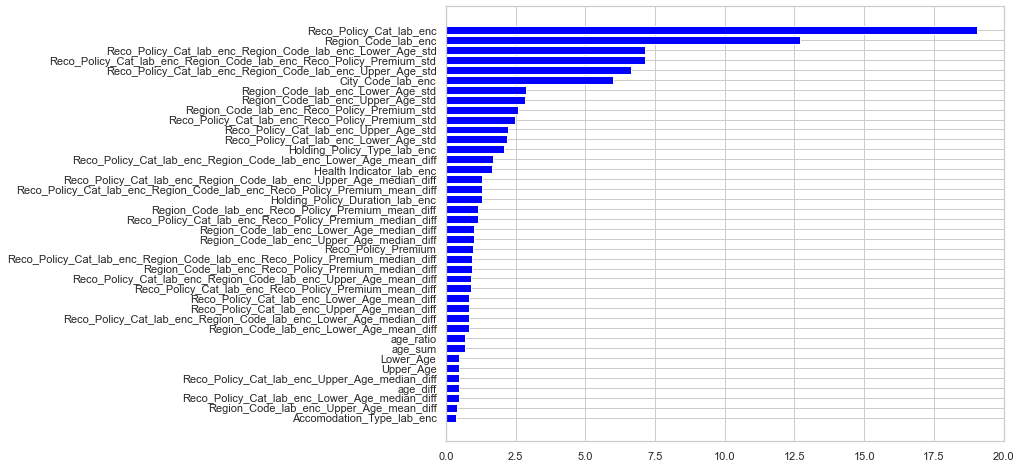

imp
Accomodation_Type_lab_enc                            0.358662
Region_Code_lab_enc_Upper_Age_mean_diff              0.404136
Reco_Policy_Cat_lab_enc_Lower_Age_median_diff        0.451045
age_diff                                             0.453358
Reco_Policy_Cat_lab_enc_Upper_Age_median_diff        0.467999
Upper_Age                                            0.475843
Lower_Age                                            0.484666
age_sum                                              0.676796
age_ratio                                            0.684840
Region_Code_lab_enc_Lower_Age_mean_diff              0.813623
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Low...   0.830882
Reco_Policy_Cat_lab_enc_Upper_Age_mean_diff          0.832674
Reco_Policy_Cat_lab_enc_Lower_Age_mean_diff          0.843466
Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_mea...   0.891847
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upp...   0.896302
Region_Code_lab_enc_Reco_Policy_Premium_median_...   0.930825
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Rec...   0.942536
Reco_Policy_Premium                                  0.986024
Region_Code_lab_enc_Upper_Age_median_diff            0.988998
Region_Code_lab_enc_Lower_Age_median_diff            1.015864
Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_med...   1.139104
Region_Code_lab_enc_Reco_Policy_Premium_mean_diff    1.153173
Holding_Policy_Duration_lab_enc                      1.283951
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Rec...   1.293851
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upp...   1.308339
Health Indicator_lab_enc                             1.654932
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Low...   1.677697
Holding_Policy_Type_lab_enc                          2.071667
Reco_Policy_Cat_lab_enc_Lower_Age_std                2.190769
Reco_Policy_Cat_lab_enc_Upper_Age_std                2.233896
Reco_Policy_Cat_lab_enc_Reco_Policy_Premium_std      2.468830
Region_Code_lab_enc_Reco_Policy_Premium_std          2.579299
Region_Code_lab_enc_Upper_Age_std                    2.817595
Region_Code_lab_enc_Lower_Age_std                    2.887398
City_Code_lab_enc                                    5.996690
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Upp...   6.636644
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Rec...   7.137984
Reco_Policy_Cat_lab_enc_Region_Code_lab_enc_Low...   7.145977
Region_Code_lab_enc                                 12.704412
Reco_Policy_Cat_lab_enc                             19.059133

In [37]:
model = models[4]
plot_cb_imp(dev_X,model,n=40)

#### create submission file

In [38]:
sub = pd.DataFrame()
sub["ID"] = test_df["ID"]
sub["Response"] = Response

In [39]:
sub.to_csv("sub10.csv",index=False)